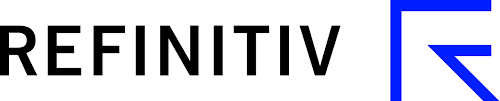

# 2022:Refinitiv Article series. All rights reserved

## Finding Option RICs

[Overview](#Overview)<br>
[Install and import packages](#Install-and-import-packages)<br>
[Section 1: Define supplementary functions](#Section-1:-Define-supplementary-functions)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.1 Function to get exchange codes where the option is traded](#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.2 Function to check if found RIC is valid (if price data exists)](#1.2-Function-to-check-if-found-RIC-is-valid-(if-price-data-exists))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.3 Function to get option Expiration month code](#1.3-Function-to-get-option-Expiration-month-code)<br>
[Section 2: Define functions to get option RICs for each exchange](#Section-2:-Define-functions-to-get-option-RICs-for-each-exchange)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.1 Function for OPRA](2.1-Function-for-OPRA)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.2 Function for the Stock Exchange of Hong Kong](#2.2-Function-for-the-Stock-Exchange-of-Hong-Kong)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.3 Function for the Osaka Stock Exchange](#2.3-Function-for-the-Osaka-Stock-Exchange)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.4 Function for OPRA](#2.4-Function-for-OPRA)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.5 Function for the Intercontinental Exchange](#2.5-Function-for-the-Intercontinental-Exchange)<br>
[Section 3: Universal function for all above exchanges](#Section-3:-Universal-function-for-all-above-exchanges)

### Overview

The current notebook includes functions to constructs option RICs on equities and indices. Section 1 defines supplementarty functions which are further called by the main RIC construction functions. In section 2, I define separate functions per supported stock exchange. Section 3, defines a universal function which takes isin, maturity, strike and option type as an input, finds all exchanges where the options on the given asset are traded, constructs RICs for them, validates and returns the constructed RICs along with the prices.

The current version covers the following exchanges:
* US OPRA - refer to RULES7, RULES2, RULES3, RULES4 in Workspace, and Guideline for strikes above 10000 in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/datanotification/DN099473.html).
* EUREX - refer to RULES2, RULES3, RULES4 in Workspace, and general option RIC structure in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html). 
* Osaka Exchange - refer to RULES2, RULES3, RULES4 in Workspace, and RIC structure for Osaka exchange in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2014/10/000189842.html).
* Stock Exchange of Hong Kong - refer to RULES2, RULES3, RULES4 in Workspace, and RIC structure for HK exchange in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2021/04/000198505.html).
* Hong Kong Future Exchange - refer to RULES2, RULES3, RULES4 in Workspace, and RIC structure for HK exchange in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2021/04/000198505.html).
* Intercontinental Exchange (ICE) - refer to RULES2, RULES3, RULES4 in Workspace, and general option RIC structure in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html). 

Syntax for the expired options is universal accross exchanges and can be found [here](https://my.refinitiv.com/content/mytr/en/faqs/2018/09/000178972.html).

## Install and import packages

To start, we first install and import the necessary packages. We use the Refinitiv Data platform API to retrieve the data. To do that, we need to authorize ourselves with an app key. The code are built using Python 3.9. Other prerequisite packages are installed below:

In [ ]:
!pip install refinitiv.data

In [1]:
import refinitiv.dataplatform as rdp
import pandas as pd
from datetime import timedelta
from datetime import datetime
# import refinitiv.data as rd

app_key = open("app_key.txt","r").read()
rdp.open_desktop_session(app_key)

### Section 1: Define supplementary functions

Functions in this section are supplementery and are further called from the functions in Section 2 and Section 3.

#### 1.1 Function to get exchange codes where the option is traded

This function allows to get the list of exchange codes where an option on the given asset is traded. The function takes asset RIC as an input and returns the list of exchanges. Then function is Section 3 constructs RICs for all supported exchanges in that list. The core of the function is the **RDP Search** function.

In [2]:
def get_exchange_code(asset):
    
    # build search query to find exchange codes where the option on the given underlying is traded  
    response = rdp.Search.search(
        query = asset,
        filter = "SearchAllCategory eq 'Options' and Periodicity eq 'Monthly' ",
        select = ' RIC, DocumentTitle, UnderlyingQuoteRIC,Periodicity, ExchangeCode',
        navigators = "ExchangeCode",
        top = 10000
    )
    result = response.data.raw["Navigators"]["ExchangeCode"]
    
    # store a=exchange codes in a list
    exchange_codes = []
    for i in range(len(result['Buckets'])):
        code = result['Buckets'][i]['Label']
        exchange_codes.append(code)
    return exchange_codes

In [3]:
get_exchange_code('.FTSE')

['IEU', 'EUX']

#### 1.2 Function to check if found RIC is valid (if price data exists)

This function allows to validate the constructed option RICs by requesting price summaries. If prices are returned we can confirm that the RIC(s) is (are) valid, otherwise we can't confirm the validation. However, the RICs with no prices can be still valid as there might not be prices because of low liquidity for certain assets with certain strike prices.

Thus, the functions print all constructed possible RICs. This function takes the option ric, maturity and dictionary of identifiers as an input and returnes ric along with the prices.

In [4]:
def check_ric(ric, maturity, ident):
    exp_date = pd.Timestamp(maturity)
    
    # get start and end date for get_historical_price_summaries query (take current date minis 90 days period)
    sdate = (datetime.now() - timedelta(90)).strftime('%Y-%m-%d')
    edate = datetime.now().strftime('%Y-%m-%d')
    
    # check if option is matured. If yes, add expiration syntax 
    # and recalculate start and end date of the query (take expiration day minus 90 days period)
    if pd.Timestamp(maturity) < datetime.now():
        ric = ric + '^' + ident[str(exp_date.month)]['exp'] + str(exp_date.year)[-2:]
        sdate = (exp_date - timedelta(90)).strftime('%Y-%m-%d')
        edate = exp_date.strftime('%Y-%m-%d')
    
    # request option prices. Please note, there is no settle price for OPRA traded options
    if ric.split('.')[1][0] == 'U':
        prices = rdp.get_historical_price_summaries(ric,  start = sdate, end = edate, interval = rdp.Intervals.DAILY,
                                                fields = ['BID','ASK','TRDPRC_1'])
    else:
        prices = rdp.get_historical_price_summaries(ric,  start = sdate, end = edate, interval = rdp.Intervals.DAILY,
                                                fields = ['BID','ASK','TRDPRC_1', 'SETTLE'])
    return ric, prices

#### 1.3 Function to get option Expiration month code

This function takes expiration date and option type as an input and returns expiration month code for the option which is further used to construct RICs

In [5]:
def get_exp_month(exp_date, opt_type):
    
    # define option expiration identifiers
    ident = {'1': {'exp': 'A','C': 'A', 'P': 'M'}, 
           '2': {'exp': 'B', 'C': 'B', 'P': 'N'}, 
           '3': {'exp': 'C', 'C': 'C', 'P': 'O'}, 
           '4': {'exp': 'D', 'C': 'D', 'P': 'P'},
           '5': {'exp': 'E', 'C': 'E', 'P': 'Q'},
           '6': {'exp': 'F', 'C': 'F', 'P': 'R'},
           '7': {'exp': 'G', 'C': 'G', 'P': 'S'}, 
           '8': {'exp': 'H', 'C': 'H', 'P': 'T'}, 
           '9': {'exp': 'I', 'C': 'I', 'P': 'U'}, 
           '10': {'exp': 'J', 'C': 'J', 'P': 'V'}, 
           '11': {'exp': 'K', 'C': 'K', 'P': 'W'}, 
           '12': {'exp': 'L', 'C': 'L', 'P': 'X'}}
    
    # get expiration month code for a month
    if opt_type.upper() == 'C':
        exp_month = ident[str(exp_date.month)]['C']
    elif opt_type.upper() == 'P':
        exp_month = ident[str(exp_date.month)]['P']
        
    return ident, exp_month

### Section 2: Define functions to get option RICs for each exchange

In this section I define functions for option RIC construction for separate exchanges. Those functions take asset RIC, maturity, strike and opt type as an input and return validated rics along with the prices. If no price is found for constructed RICs, the functions print out possible RICs.

#### 2.1 Function for OPRA

Below function returns option RICs for OPRA exchange.

In [18]:
def get_ric_opra(asset, maturity, strike, opt_type):
    exp_date = pd.Timestamp(maturity)
    
    # trim underlying asset's RIC to get the required part for option RIC
    if asset[0] == '.': # check if the asset is an index or an equity
        asset_name = asset[1:] # get the asset name - we remove "." symbol for index options
    else:
        asset_name = asset.split('.')[0] # we need only the first part of the RICs for equities
    
    ident = {'1': {'exp': 'A', 'C_bigStrike': 'a','C_smallStrike': 'A', 'P_bigStrike': 'm', 'P_smallStrike': 'M'}, 
           '2': {'exp': 'B', 'C_bigStrike': 'b','C_smallStrike': 'B', 'P_bigStrike': 'n', 'P_smallStrike': 'N'}, 
           '3': {'exp': 'C', 'C_bigStrike': 'c','C_smallStrike': 'C', 'P_bigStrike': 'o', 'P_smallStrike': 'O'}, 
           '4': {'exp': 'D', 'C_bigStrike': 'd','C_smallStrike': 'D', 'P_bigStrike': 'p', 'P_smallStrike': 'P'},
           '5': {'exp': 'E', 'C_bigStrike': 'e','C_smallStrike': 'E', 'P_bigStrike': 'q', 'P_smallStrike': 'Q'},
           '6': {'exp': 'F', 'C_bigStrike': 'f','C_smallStrike': 'F', 'P_bigStrike': 'r', 'P_smallStrike': 'R'},
           '7': {'exp': 'G', 'C_bigStrike': 'g','C_smallStrike': 'G', 'P_bigStrike': 's', 'P_smallStrike': 'S'}, 
           '8': {'exp': 'H', 'C_bigStrike': 'h','C_smallStrike': 'H', 'P_bigStrike': 't', 'P_smallStrike': 'T'}, 
           '9': {'exp': 'I', 'C_bigStrike': 'i','C_smallStrike': 'I', 'P_bigStrike': 'u', 'P_smallStrike': 'U'}, 
           '10': {'exp': 'J', 'C_bigStrike': 'j','C_smallStrike': 'J', 'P_bigStrike': 'v', 'P_smallStrike': 'V'}, 
           '11': {'exp': 'K', 'C_bigStrike': 'k','C_smallStrike': 'K', 'P_bigStrike': 'w', 'P_smallStrike': 'W'}, 
           '12': {'exp': 'L', 'C_bigStrike': 'l','C_smallStrike': 'L', 'P_bigStrike': 'x', 'P_smallStrike': 'X'}}
    
    # get expiration month code for a month
    if opt_type.upper() == 'C':
        if strike > 999.999:
            exp_month = ident[str(exp_date.month)]['C_bigStrike']
        else:
            exp_month = ident[str(exp_date.month)]['C_smallStrike']
            
    # calculate the strike price and get expiration month code for a month for put options
    elif opt_type.upper() == 'P':
        if strike > 999.999:
            exp_month = ident[str(exp_date.month)]['P_bigStrike'] 
        else:
            exp_month = ident[str(exp_date.month)]['P_smallStrike']
    
    # get strike prrice
    if type(strike) == float:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])
    else:
        int_part = int(strike)
        dec_part = '00'
    if len(dec_part) == 1:
        dec_part = dec_part + '0'

    if int(strike) < 10:
        strike_ric = '00' + str(int_part) + dec_part
    elif int_part >= 10 and int_part < 100:
        strike_ric = '0' + str(int_part) + dec_part
    if int_part >= 100 and int_part < 1000:
        strike_ric = str(int_part) + dec_part
    elif int_part >= 1000 and int_part < 10000:
        strike_ric = str(int_part) + '0'
    elif int_part >= 10000 and int_part < 20000:
        strike_ric = 'A' + str(int_part)[-4:]
    elif int_part >= 20000 and int_part < 30000:
        strike_ric = 'B' + str(int_part)[-4:]      
    elif int_part >= 30000 and int_part < 40000:
        strike_ric = 'C' + str(int_part)[-4:]
    elif int_part >= 40000 and int_part < 50000:
        strike_ric = 'D' + str(int_part)[-4:]
        
    # build initial ric
    ric = asset_name + exp_month + str(exp_date.day) + str(exp_date.year)[-2:] + strike_ric + '.U'
    # check ric validity
    ric, prices = check_ric(ric, maturity, ident)
    
    # return valid rics or append to the possible_ric list if no price is found
    possible_rics = [] 
    if prices is not None:
        return ric, prices
    else:
        possible_rics.append(ric)
        print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return ric, prices

In [19]:
ric, prices = get_ric_opra('AAPL.O', '2022-01-21', 180, 'C')

In [20]:
ric

'AAPLA212218000.U^A22'

In [21]:
prices.head()

,TRDPRC_1,BID,ASK
2021-10-22,0.54,0.51,0.54
2021-10-25,0.5,0.49,0.52
2021-10-26,0.55,0.53,0.55
2021-10-27,0.6,0.59,0.62
2021-10-28,0.82,0.75,0.84


#### 2.2 Function for the Stock Exchange of Hong Kong

Below function returns option RICs for Hong Kong exchange.

In [22]:
def get_ric_hk(asset, maturity, strike, opt_type):
    exp_date = pd.Timestamp(maturity)
    
    # get asset name and strike price for the asset
    if asset[0] == '.': 
        asset_name = asset[1:] 
        strike_ric = str(int(strike))
    else:
        asset_name = asset.split('.')[0]
        strike_ric = str(int(strike * 100))
     
    # get expiration month codes
    ident, exp_month = get_exp_month(exp_date, opt_type)

    possible_rics = []
    # get rics for options on indexes. Return if valid add to the possible_rics list if no price is found
    if asset[0] == '.':
        ric = asset_name + strike_ric + exp_month + str(exp_date.year)[-1:] + '.HF'
        ric, prices = check_ric(ric, maturity, ident)
        if prices is not None:
            return ric, prices
        else:
            possible_rics.append(ric)
    else:
        # get rics for options on equities. Return if valid add to the possible_rics list if no price is found
        # there could be several generations of options depending on the number of price adjustments due to a corporate event
        # here we use 4 adjustment opportunities.
        for i in range(4): 
            ric = asset_name + strike_ric + str(i)+ exp_month + str(exp_date.year)[-1:] + '.HK'
            ric, prices = check_ric(ric, maturity, ident)
            if prices is not None:
                 return ric, prices # we return ric and prices for the first found ric (we don't check for other adjusted rics)
            else:
                possible_rics.append(ric)
    print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return  ric, prices

In [23]:
ric, prices = get_ric_hk('.HSI', '2022-03-30', 18400, 'C')

In [24]:
ric

'HSI18400C2.HF^C22'

In [25]:
prices.head()

,TRDPRC_1,BID,ASK,SETTLE
2021-12-29,<NA>,<NA>,<NA>,4651
2021-12-30,<NA>,<NA>,<NA>,4732
2021-12-31,<NA>,<NA>,<NA>,5016
2022-01-03,<NA>,<NA>,<NA>,4826
2022-01-04,<NA>,<NA>,<NA>,4862


#### 2.3 Function for the Osaka Stock Exchange

Below function returns option RICs for Osaka exchange.

In [26]:
def get_ric_ose(asset, maturity, strike, opt_type):
    exp_date = pd.Timestamp(maturity)

    if asset[0] == '.':
        asset_name = asset[1:]
    else:
        asset_name = asset.split('.')[0]
    strike_ric = str(strike)[:3]
        
    ident, exp_month = get_exp_month(exp_date, opt_type)
    
    possible_rics = []
    if asset[0] == '.':
        # Option Root codes for indexes are different from the RIC, so we rename where necessery
        if asset_name == 'N225':
            asset_name = 'JNI'
        elif asset_name == 'TOPX':
            asset_name = 'JTI'
        # we consider also J-NET (Off-Auction(with "L")) and High  frequency (with 'R') option structures 
        for jnet in ['', 'L', 'R']:
            ric = asset_name + jnet + strike_ric + exp_month + str(exp_date.year)[-1:] + '.OS'
            ric, prices = check_ric(ric, maturity, ident)
            if prices is not None:
                return ric, prices
            else:
                possible_rics.append(ric)
    else:
        generations = ['Y', 'Z', 'A', 'B', 'C'] # these are generation codes similar to one from HK 
        for jnet in ['', 'L', 'R']:
            for gen in generations:
                ric = asset_name + jnet + gen + strike_ric + exp_month + str(exp_date.year)[-1:] + '.OS'
                ric, prices = check_ric(ric, maturity, ident)
                if prices is not None:
                    return ric, prices
                else:
                    possible_rics.append(ric)
    print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return  ric, prices

In [27]:
ric, prices = get_ric_ose('7974.T', '2022-03-30', 50000, 'P')

In [28]:
ric

'7974Y500O2.OS^C22'

In [29]:
prices.head()

,TRDPRC_1,BID,ASK,SETTLE
2021-12-29,None,None,None,1609.0
2021-12-30,None,None,None,1777.0
2022-01-04,None,None,None,1516.0
2022-01-05,None,None,None,1647.0
2022-01-06,None,None,None,1848.0


#### 2.4 Function for the EUREX

Below function returns option RICs for EUREX exchange.

In [30]:
def get_ric_eurex(asset, maturity, strike, opt_type):
    exp_date = pd.Timestamp(maturity)

    if asset[0] == '.': 
        asset_name = asset[1:]
        if asset_name == 'FTSE':
            asset_name = 'OTUK'
        elif asset_name == 'SSMI':
            asset_name = 'OSMI'
        elif asset_name == 'GDAXI':
            asset_name = 'GDAX'
        elif asset_name == 'ATX':
            asset_name = 'FATXA'
        elif asset_name == 'STOXX50E':
            asset_name = 'STXE'           
    else:
        asset_name = asset.split('.')[0]
        
    ident, exp_month = get_exp_month(exp_date, opt_type)
        
    if type(strike) == float:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])[0]
    else:
        int_part = int(strike)
        dec_part = '0'      
        
    if len(str(int(strike))) == 1:
        strike_ric = '0' + str(int_part) + dec_part
    else:
        strike_ric = str(int_part) + dec_part
    
    possible_rics = []
    generations = ['', 'a', 'b', 'c', 'd']
    for gen in generations:
        ric = asset_name + strike_ric  + gen + exp_month + str(exp_date.year)[-1:] + '.EX'
        ric, prices = check_ric(ric, maturity, ident)
        if prices is not None:
            return ric, prices
        else:
            possible_rics.append(ric)
    print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return  ric, prices

In [31]:
ric, prices = get_ric_eurex('.STOXX50E', '2022-03-30', 4200, 'P')

In [32]:
ric

'STXE42000O2.EX^C22'

In [33]:
prices.head()

,TRDPRC_1,BID,ASK,SETTLE
2021-12-29,112.5,110.8,114.4,112.9
2021-12-30,100.7,101.5,104.1,102.5
2022-01-03,91.1,87.3,88.8,88
2022-01-04,72.8,79.7,82.8,81.2
2022-01-05,69.4,68.4,71.5,70.3


#### 2.5 Function for the Intercontinental Exchange

Below function returns option RICs for Intercontinental Exchange exchange.

In [34]:
def get_ric_ieu(asset, maturity, strike, opt_type):
    exp_date = pd.Timestamp(maturity)
    
    if asset[0] == '.':
        asset_name = asset[1:]
        if asset_name == 'FTSE':
            asset_name = 'LFE'       
    else:
        asset_name = asset.split('.')[0] 
        
    ident, exp_month = get_exp_month(exp_date, opt_type)

    if len(str(int(strike))) == 2:
        strike_ric = '0' + str(int(strike))
    else:
        strike_ric = str(int(strike))
        
    if type(strike) == float and len(str(int(strike))) == 1:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])[0]        
        strike_ric = '0' + str(int_part) + dec_part
    
    possible_rics = []
    generations = ['', 'a', 'b', 'c', 'd']
    for gen in generations:
        ric = asset_name + strike_ric  + gen + exp_month + str(exp_date.year)[-1:] + '.L'
        ric, prices = check_ric(ric, maturity, ident)
        if prices is not None:
            return ric, prices
        else:
            possible_rics.append(ric)
    print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return  ric, prices

In [35]:
ric, prices = get_ric_ieu('.FTSE', '2022-06-30', 7000, 'C')

In [36]:
ric

'LFE7000F2.L'

In [37]:
prices.head()

,TRDPRC_1,BID,ASK,SETTLE
2022-01-19,<NA>,629.5,654.0,630.5
2022-01-20,<NA>,611.0,637.5,619.0
2022-01-21,<NA>,543.0,577.0,564.5
2022-01-24,<NA>,410.0,470.5,472.0
2022-01-25,<NA>,492.5,530.0,515.0


### Section 3: Universal function for all above exchanges

In this section I built a universal function which takes isin, maturity, strike and option type as an input, finds all exchanges where the options on given asset are traded, constructs RICs for them, validates and returns the constructed RICs along with the prices. Here again, If no price is found for constructed RICs, the functions print out possible RICs.

In [38]:
def get_optionRic(isin, maturity, strike, opt_type):
    
    # define covered exchanges along with functions to get RICs from
    exchanges = {'OPQ': get_ric_opra,
           'IEU': get_ric_ieu,
           'EUX': get_ric_eurex,
           'HKG': get_ric_hk,
           'HFE': get_ric_hk,
           'OSA': get_ric_ose}
    
    # convert ISIN to RIC
    df = rdp.convert_symbols( isin, from_symbol_type = "ISIN" , to_symbol_types = "RIC")
    ricUnderlying = df['RIC'][0]
    
    # get exchanges codes where the option on the given asset is traded
    exchnage_codes = get_exchange_code(ricUnderlying)
    
    # get the list of (from all available and covered exchanges) valid rics and their prices
    option_rics = [] 
    priceslist = []
    for exch in exchnage_codes:
        if exch in exchanges.keys():
            ric, prices = exchanges[exch](ricUnderlying, maturity, strike, opt_type)
            if prices is not None:
                option_rics.append(ric)
                priceslist.append(prices)
                print(f'Option RIC for {exch} exchange is successfully constructed')     
        else:
            print(f'The {exch} exchange is not supported yet')
    return option_rics, priceslist

In [39]:
# option_rics, priceslist = get_optionRic('CH0012221716', '2022-03-30', 34, 'C')
# option_rics, priceslist = get_optionRic('DE0008404005', '2022-03-18', 220, 'C')
# option_rics, priceslist = get_optionRic('ES0113211835', '2022-03-18', 4.7, 'C')
# option_rics, priceslist = get_optionRic('FR0000120073', '2022-03-18', 150, 'C')
# option_rics, priceslist = get_optionRic('GB0031348658', '2022-03-18', 210, 'P')
option_rics, priceslist = get_optionRic('GB0009895292', '2022-03-18', 9000, 'P')
# option_rics, priceslist = get_optionRic('GB00BH4HKS39', '2022-03-18', 100, 'P')
# option_rics, priceslist = get_optionRic('FR0010220475', '2022-06-18', 36, 'P')
# option_rics, priceslist = get_optionRic('FR0000131104', '2022-03-18', 70, 'P')
# option_rics, priceslist = get_optionRic('IT0003132476', '2022-06-16', 13, 'C')
# option_rics, priceslist = get_optionRic('NL0010273215', '2022-02-18', 640, 'P')
# option_rics, priceslist = get_optionRic('HK0000004322', '2022-03-30', 18400, 'C')
# option_rics, priceslist = get_optionRic('HK1093012172', '2022-03-30', 10, 'C')
# option_rics, priceslist = get_optionRic('KYG875721634', '2022-04-28', 480, 'C')
# option_rics, priceslist = get_optionRic('JP9010100007', '2022-06-10', 1900, 'C')
# option_rics, priceslist = get_optionRic('JP3788600009', '2022-06-10', 6500, 'C')
# option_rics, priceslist = get_optionRic('GB0001383545', '2022-03-18', 7650, 'C')
# option_rics, priceslist = get_optionRic('EU0009658145', '2022-03-18', 4200, 'C')
# option_rics, priceslist = get_optionRic('JP9010C00002', '2022-01-17', 25875, 'C')
# option_rics, priceslist = get_optionRic('US90184L1026', '2022-01-21', 40, 'C')
# option_rics, priceslist = get_optionRic('US78378X1072', '2022-02-18', 5000, 'C')

Option RIC for IEU exchange is successfully constructed
Option RIC for EUX exchange is successfully constructed


In [40]:
option_rics

['AZN9000O2.L^C22', 'AZN90000O2.EX^C22']

In [41]:
priceslist[0]

,TRDPRC_1,BID,ASK,SETTLE
2021-12-17,741,705.5,816.0,784.0
2021-12-20,<NA>,776.0,796.0,802.5
2021-12-21,<NA>,697.5,717.0,706.0
2021-12-22,<NA>,683.5,703.5,692.0
2021-12-23,<NA>,669.0,687.0,694.0
...,...,...,...,...
2022-03-11,<NA>,64.5,86.5,82.0
2022-03-14,<NA>,29.5,44.5,35.0
2022-03-15,36,22.0,37.0,21.5
2022-03-16,<NA>,5.0,12.5,7.5


### Conclusion

Current article preseneted functions to find valid RICs for options on stock and indices traded in several exchanges. Additionally, I presented a universal function which finds the exchanges where an option on a given asset is traded, constructs RICs for them, validates and returns the constructed RICs along with the price.

The current version of this article is limited for certain exchanges, includig OPRA, EUREX, ICE, Hong Kong and Osaka, and for options on certain asset types, including indices and stocks. Please let me know which other exchanges and/or options on other asset categories you want me to build functions for. You can contact me directly via h.aramyan@refinitiv.com or raise your questions/suggestion via Q&A portal of Developer community.